# SMV2rho: Tutorial 5

In this tutorial we will see how we can include temperature dependence within the density conversion scheme.  Note that this is only pssible with the `SMV2rho`/`'stephenson'` scheme because the `'brocher'` approach is explicitly not a temperature- or -pressure dependent approach and so we do not recommend including this dependency with this scheme.

Secondly, we will explore the option to set the uppermost layer of the crust to have a constant density.  This option allows us to exclude the portion of the crust that experiences an exponential velocity drop-off.

In [1]:
# import modules
import numpy as np
from SMV2rho import plotting as smplt
from SMV2rho import density_functions as smd
from SMV2rho import constants as c
from SMV2rho import temperature_dependence as td

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Class approach

Again we will first go through this procedure step-by-step so that we can query the outputs.

### Load file

Let's define the velocity profile that we are interested in converting, initialise the Convert and Constants classes and read in the profile data file.

In [2]:
# path to test velocity file
#  - this file comes with the distribution so there is no need to change this path
vp_file = "../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat"

# create the constants object.
constants = c.Constants()


## Creating the `geotherm` object

For a temperature-dependent parametrisation, we must provide an estimate of the temperature structure at depth.  To do so, we need to parameterise the geothermal gradient.  `SMV2rho` incorporates a number of geothermal parametrisations, with hopefully more to come.

To create the geotherm object, we frst instantiate the `Geotherm` class within the `temperature_dependence` module.  At this stage, we can select a number of different parametrisations for the geotherm, including a simple, linear geotherm or various different approches that solve the 1D heat equation with internal heat production.  When geotherm you pick will depend on the constraints present (e.g. Moho temnperature vs heat flux etc.).  the default option is `'linear'`, i.e. a simple geotherm that is linear and defined by surface and basal temperature.  Please see the documentation for the `Geotherm` class and the `GeothermConstants` dataclass for more information.

Note that for the `Geotherm` class, depths, including crustal thickness, depth below surface, and the depth range over which geothermal heat production decays away **must be given in metres**.  This idiosyncracy will hopefully be fixed in future issues.

below we will generate three geotherms usig different methods.  Note all will use default values stored in the `GeothermConstants` data class, which can all be set manually when creating the geotherm object.  Simple type, for example `geotherm = td.Geotherm(tc = 30000, k = 3.0, H0 = 7.5e-10 ...)` to select manual options.

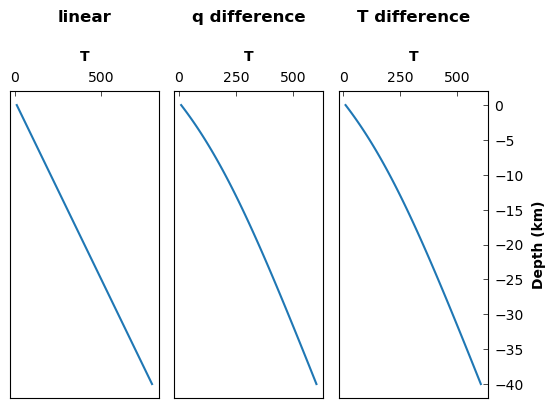

In [3]:
# create a depth array for plotting
z = np.linspace(0, 40000, 100)

# create a linear geotherm object providing a crustal thickness (in m)
geotherm1 = td.Geotherm(tc = 30000)
# calculate the geotherm by calling the geotherm class
T_arr1 = geotherm1(z)

# create a geotherm object that depends on heat flux at surface and moho
# note this does not require a crustal thickness argument
geotherm2 = td.Geotherm(geotherm_type = 'single_layer_flux_difference')
T_arr2 = geotherm2(z)

# create a geotherm object that depends on temperature at the surface and at the moho
geotherm3 = td.Geotherm(geotherm_type = 'single_layer_temperature_difference', tc = 30000)
T_arr3 = geotherm3(z)

#### PLOTTING ####

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': T_arr1, 'y':-z/1000}]
data2 = [{'x':  T_arr2, 'y':-z/1000}]
data3 = [{'x':  T_arr2, 'y': -z/1000}]

titles = ['linear', 'q difference', 'T difference']
xlabels = ['T', 'T', 'T']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# Call the plot_panels function
smplt.plot_panels(
    [data1, data2, data3], 
    plot_type='line', 
    cmap=None, titles=titles, 
    xlabels=xlabels, 
    ylabels=ylabels,
    z_values=None, 
    figure_scale=0.7, 
    save_path=None)

Let's create the geotherm object for the vlocity profile that we are looking at...

In [4]:
geotherm = td.Geotherm(geotherm_type = 'single_layer_flux_difference')

## Convert Profile

This time we will set `T_dependence = True`, which is the default setting so we won't bother passing it as an argument.  This option will prompt the program to look for a a `material_constants` attribute within the `constants` class instance.  At the moment, this object does not exist and so the program will throw an error!

In [5]:
# load a profile into the Convert class
profile = smd.Convert(
    vp_file, 
    profile_type = "Vp",
    geotherm = geotherm
    )

# read data
profile.read_data()

# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(
    constants, 
    T_dependence = True
    )

ValueError: T_dependence is set to True but material_constants instance of the Constants class has not been set.

We can now set up the constants object by calling the `get_v_constants` method as in the last tutorial.  This time we will also call the `get_material_constants` method which will generate the constants for the temperature-dependent part of the conversion.

In [6]:
# call the get_v_constants method asking for Vp constants
constants.get_v_constants('Vp')

# call the get_material_constants method
constants.get_material_constants()

print(constants)

Constants(vp_constants=VpConstants(v0=-0.93521, b=0.00169478, d0=2.55911, dp=-0.00047605, c=1.674065, k=0.01953466, m=-0.0004), vs_constants=None, material_constants=MaterialConstants(alpha0=1e-05, alpha1=2.9e-08, K=90000000000.0, dalpha0=5e-06, dalpha1=5e-09, dK=20000000000.0))


We can see that the constants object now contains a VpConstants object and a MaterialsConstants object.

Now we can run the conversion again and this time it will work.

Note, as with the previous tutorial, running this function may result in an integration warning.  This warning can be safely ignored and is generated because the velocity and density profile functions $V_P(z)$ and $\rho (z)$ contain discontinuities.

In [7]:
constants.material_constants

MaterialConstants(alpha0=1e-05, alpha1=2.9e-08, K=90000000000.0, dalpha0=5e-06, dalpha1=5e-09, dK=20000000000.0)

In [8]:
# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(constants, T_dependence = True)

profile.data.keys()

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1638: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


dict_keys(['station', 'Vp_file', 'region', 'moho', 'location', 'av_Vp', 'Vp', 'type', 'method', 'rho', 'av_rho', 'rho_hi_res', 'Vp_hi_res', 'p', 'T'])

## Outputs and plotting

We can now explore the outputs.  We can already see that we now have a `'T'` key within the output dictionary.  This temperature profile is generated using a constant moho and surface heat flux with heat production concentrated within the upper 10 km.  It is possible to edit the parametrisation of the geotherm  within the `temperature_dependence` and `density_functions` modules.

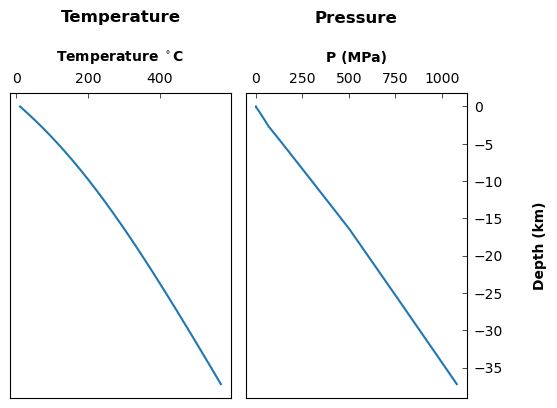

In [9]:
# Define plot settings
plot_type = 'line'
titles = ['Temperature', 'Pressure']
xlabels = [r'Temperature $^\circ$C', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["T"][:,1], 'y': profile.data["T"][:,0]}]
data2 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels(
    [data1, data2], 
    plot_type=plot_type, 
    cmap=None, titles=titles, 
    xlabels=xlabels, 
    ylabels=ylabels,
    z_values=None, 
    figure_scale=0.7, 
    save_path=None)

Now let's plot up the velocity and density curves

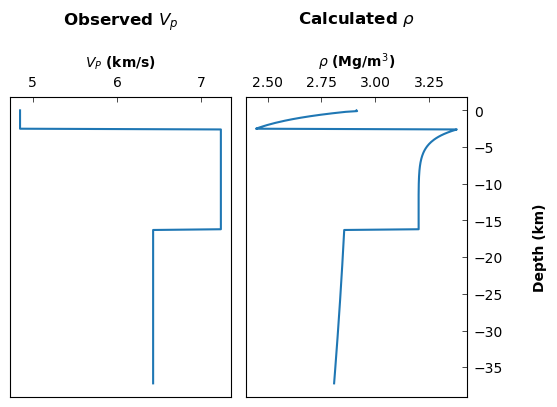

In [10]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)']
ylabels = ['Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho_hi_res"][:,1], 'y': profile.data["rho_hi_res"][:,0]}]

# Call the plot_panels function
smplt.plot_panels(
    [data1, data2], 
    plot_type=plot_type, 
    cmap=None, titles=titles, 
    xlabels=xlabels, 
    ylabels=ylabels,
    z_values=None, 
    figure_scale=0.7, 
    save_path=None)

### Function approach

Again, it is possible by eusing the options in the `convert_V_profile` function to convert this velocity profile using a function rather than step-bystep using the class objects.

In [12]:
# call density conversion function
# note that using profile_type="Vs" first calls a function to convert to Vp
# as is required by Brocher's (2005) approach.
profile_stephenson = smd.convert_V_profile(
    vp_file, 
    profile_type="Vp", 
    approach="stephenson",
    print_working_file = True,
    parameters = constants,
    T_dependence = True,
    geotherm = geotherm
    )


working on ../TEST_DATA/EUROPE/Vp/RECEIVER_FUNCTION/DATA/M19_AQU_Vp.dat


/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1638: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


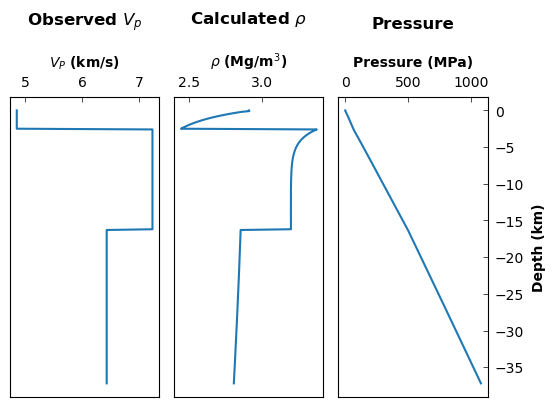

In [14]:
# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile_stephenson["Vp_hi_res"][:,1], 'y': profile_stephenson["Vp_hi_res"][:,0]}]
data2 = [{'x': profile_stephenson["rho_hi_res"][:,1], 'y': profile_stephenson["rho_hi_res"][:,0]}]
data3 = [{'x': profile_stephenson["p"][:,1], 'y': profile_stephenson["p"][:,0]}]

titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'Pressure (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# Call the plot_panels function
smplt.plot_panels(
    [data1, data2, data3], 
    plot_type=plot_type, 
    cmap=None, titles=titles, 
    xlabels=xlabels, 
    ylabels=ylabels,
    z_values=None, 
    figure_scale=0.7, 
    save_path=None)

## Excluding the uppermost $x$ km

We can exclude the uppermost $x$ km from the density conversion, setting it to a constant value in order to avoid mismatches between exponential drop-off in the density conversion scheme that may or may not be present in the true velocity profile.  This effect can be seen in the above example, where the layers are relatively coarse, and so an exponential veocity dropoff is imposed upon a layer of constant velocity.

To avoid this mismatch, we can set the `constant_density` and `constant_depth` parameters.  Both of these parameters must be set together.

In [17]:
# calculate density profile -- note default is the temperature dependence is True!
profile.V_to_density_stephenson(
    constants, 
    T_dependence = True,
    constant_density = 2.75, 
    constant_depth = 7)

/Users/eart0518/Work/SMV2rho/src/SMV2rho/density_functions.py:1638: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  int_val = integrate.quad(interp_profile, bins_low_res[e],


Now we can plot the `'rho_hi_res'` array and see that the uppermost 7 km have been set to a density of 2.75 Mg/m<sup>3</sup>.  Note that if we are using the `temperature_dependence = True` option, then we are setting $\rho_\circ$ to constant, but this density value will still be subject to thermal expansion and compression.

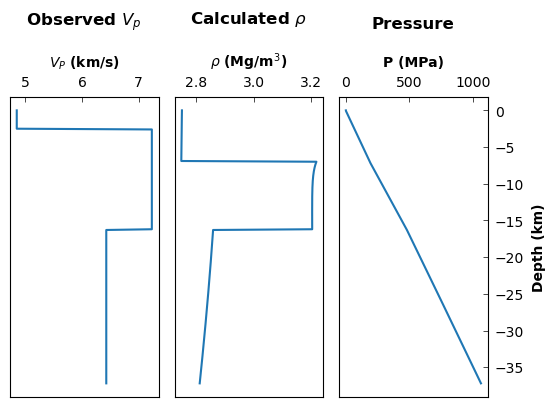

In [18]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho_hi_res"][:,1], 'y': profile.data["rho_hi_res"][:,0]}]
data3 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels(
    [data1, data2, data3], 
    plot_type=plot_type, 
    cmap=None, titles=titles, 
    xlabels=xlabels, 
    ylabels=ylabels,
    z_values=None, 
    figure_scale=0.7, 
    save_path=None)

And now we can plot the `'rho'` array to see what the profile looks like after averaging into the same layers as contained in the input velocity profile.

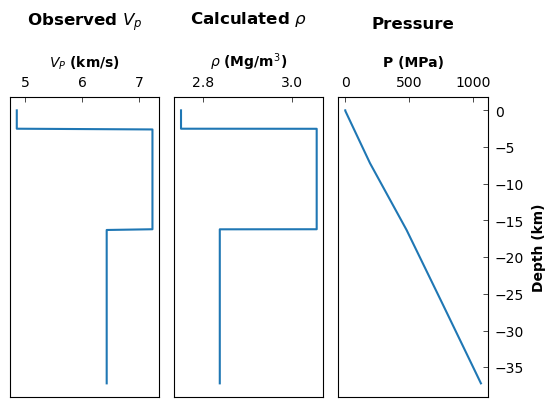

In [19]:
# Define plot settings
plot_type = 'line'
titles = [r'Observed ${V_p}$', r'Calculated $\rho$', 'Pressure']
xlabels = [r'${V_P}$ (km/s)', r'$\rho$ (Mg/m${^3}$)', 'P (MPa)']
ylabels = ['Depth (km)', 'Depth (km)', 'Depth (km)']

# data1, data2 and data3 -- list of dictionaries for each panel for each data series.
data1 = [{'x': profile.data["Vp_hi_res"][:,1], 'y': profile.data["Vp_hi_res"][:,0]}]
data2 = [{'x': profile.data["rho"][:,1], 'y': profile.data["rho"][:,0]}]
data3 = [{'x': profile.data["p"][:,1], 'y': profile.data["p"][:,0]}]

# Call the plot_panels function
smplt.plot_panels(
    [data1, data2, data3], 
    plot_type=plot_type, 
    cmap=None, titles=titles, 
    xlabels=xlabels, 
    ylabels=ylabels,
    z_values=None, 
    figure_scale=0.7, 
    save_path=None)

## Summary

We have now included temperature dependence within the density conversion scheme.  We have explored how to create an instance of the `Constants` class including a `material_constants` object and we have explored how to set the uppermost $x$ km to a constant value to mitigate cases where the expected exponential dropoff in velocity is not reflected in the velocity profile.